In [1]:
import sys
sys.path.append('../')
from util import indicator, data, display

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from prophet import Prophet

def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def calculate_ichimoku(df):
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['conversion_line'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['base_line'] = (high_26 + low_26) / 2

    df['leading_span_a'] = ((df['conversion_line'] + df['base_line']) / 2).shift(26)

    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['leading_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['lagging_span'] = df['Close'].shift(-26)

    return df

def forecast_stock_price(df, forecast_days):
    prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    future_dates = model.make_future_dataframe(periods=forecast_days)
    
    forecast = model.predict(future_dates)
    
    return forecast

def extend_ichimoku(df, forecast):
    forecast_start = df.index[-1] + timedelta(days=1)
    forecast_end = forecast_start + timedelta(days=len(forecast) - len(df) - 1)
    forecast_index = pd.date_range(start=forecast_start, end=forecast_end)
    
    forecast_df = pd.DataFrame(index=forecast_index, columns=df.columns)
    forecast_df['Close'] = forecast.loc[forecast['ds'].isin(forecast_index), 'yhat'].values
    forecast_df['High'] = forecast.loc[forecast['ds'].isin(forecast_index), 'yhat_upper'].values
    forecast_df['Low'] = forecast.loc[forecast['ds'].isin(forecast_index), 'yhat_lower'].values
    
    extended_df = pd.concat([df, forecast_df])
    
    return calculate_ichimoku(extended_df)

def plot_ichimoku(df, forecast, specific_date):
    plt.figure(figsize=(15, 7))
    
    actual_data = df[df.index <= specific_date]
    forecast_data = df[df.index > specific_date]

    plt.plot(actual_data.index, actual_data['Close'], label='Actual Close', color='black')
    plt.plot(df.index, df['conversion_line'], label='Conversion Line', color='blue')
    plt.plot(df.index, df['base_line'], label='Base Line', color='red')
    plt.plot(df.index, df['leading_span_a'], label='Leading Span A', color='green')
    plt.plot(df.index, df['leading_span_b'], label='Leading Span B', color='red')
    plt.plot(df.index, df['lagging_span'], label='Lagging Span', color='purple')
    
    plt.plot(forecast_data.index, forecast_data['Close'], label='Forecasted Close', color='orange', linestyle='--')

    plt.fill_between(df.index, df['leading_span_a'], df['leading_span_b'], 
                     where=df['leading_span_a'] >= df['leading_span_b'], facecolor='lightgreen', alpha=0.5)
    plt.fill_between(df.index, df['leading_span_a'], df['leading_span_b'], 
                     where=df['leading_span_a'] < df['leading_span_b'], linestyle='--', facecolor='lightcoral', alpha=0.5)

    plt.axvline(x=specific_date, color='gray', linestyle='--', label='Forecast Start')

    specific_price = df.loc[specific_date, 'Close']
    plt.plot(specific_date, specific_price, 'ro', markersize=10)
    plt.annotate(f'{specific_date.date()}: {specific_price:.2f}', 
                 (specific_date, specific_price),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle="round", fc="yellow", ec="b", alpha=0.8),
                 arrowprops=dict(arrowstyle="->"))

    last_forecast_date = forecast_data.index[-1]
    last_forecast_price = forecast_data['Close'].iloc[-1]
    plt.plot(last_forecast_date, last_forecast_price, 'go', markersize=10)
    plt.annotate(f'{last_forecast_date.date()}: {last_forecast_price:.2f}', 
                 (last_forecast_date, last_forecast_price),
                 xytext=(10, -10), textcoords='offset points',
                 bbox=dict(boxstyle="round", fc="lightgreen", ec="g", alpha=0.8),
                 arrowprops=dict(arrowstyle="->"))

    plt.title('Ichimoku Kinko Hyo with Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    

[*********************100%%**********************]  1 of 1 completed
17:03:57 - cmdstanpy - INFO - Chain [1] start processing
17:03:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\kwkim\AppData\Local\Temp\ipykernel_12728\1441504580.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_df = pd.concat([df, forecast_df])


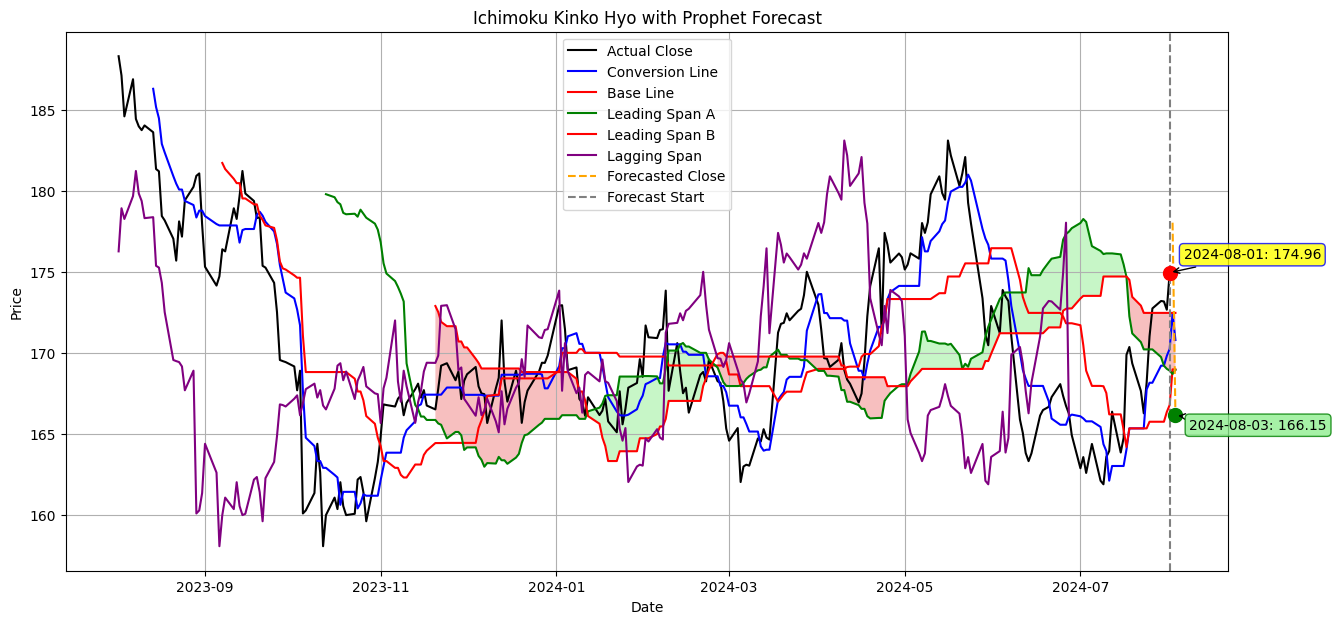

2024년 8월 1일 종가: 178.04
1일 후 예측 종가: 166.15


In [28]:
# 메인 실행 부분
ticker = "PEP"
specific_date = pd.Timestamp('2024-08-1')
forecast_days = 1

start_date = specific_date - timedelta(days=365)
end_date = pd.Timestamp('2024-09-1')

stock_data = get_stock_data(ticker, start_date, end_date)
forecast = forecast_stock_price(stock_data, forecast_days)
extended_ichimoku_data = extend_ichimoku(stock_data, forecast)

plot_ichimoku(extended_ichimoku_data, forecast, specific_date)

print(f"2024년 8월 1일 종가: {stock_data['Close'].iloc[-1]:.2f}")
print(f"{forecast_days}일 후 예측 종가: {extended_ichimoku_data['Close'].iloc[-1]:.2f}")

In [16]:
stock_data.loc['2024-07-29':'2024-08-05',:]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-29,113.690002,116.279999,111.300003,111.589996,111.589996,248152100
2024-07-30,111.519997,111.989998,102.540001,103.730003,103.730003,486833300
2024-07-31,112.900002,118.339996,110.879997,117.019997,117.019997,473174200
2024-08-01,117.529999,120.160004,106.809998,109.209999,109.209999,523462300
2024-08-02,103.760002,108.720001,101.370003,107.269997,107.269997,480242500
